## Data Import 

In [113]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm
from tools import utils as util
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import tools as tool

In [4]:
data = pd.read_csv('data/House_Price.csv')

In [5]:
#selecting all columns that do not have numeric values
object_column = data.select_dtypes(include = ['object']).columns.tolist()

## Feature Processing (One Hot Encoding)

In [6]:
for column in object_column:
    data = util.one_hot_encoding(data, column)
ohc_data = data

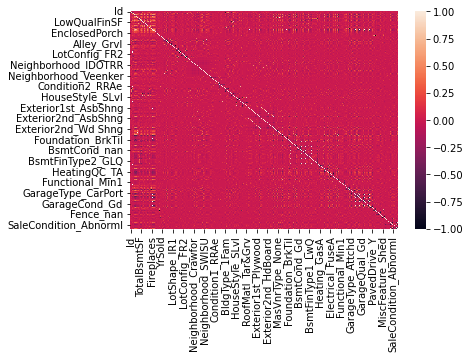

In [7]:
sns_plot = sns.heatmap(ohc_data.corr())
fig = sns_plot.get_figure()
fig.savefig("figures/ohc_data_heatmap")

In [8]:
threshold = 0.7

df_corr = ohc_data.corr()

columns = np.full((df_corr.shape[0],), True, dtype=bool)

for i in range(df_corr.shape[0]):
    for j in range(i+1, df_corr.shape[0]):
        if df_corr.iloc[i,j] >= threshold:
            if columns[j]:
                columns[j] = False


selected_columns = ohc_data.columns[~columns]
high_correlation = ohc_data[selected_columns]

In [9]:
absolute_corr = np.abs(df_corr["SalePrice"])
df_corr["SalePrice"][absolute_corr > 0.5]

OverallQual       0.790982
YearBuilt         0.522897
YearRemodAdd      0.507101
TotalBsmtSF       0.613581
1stFlrSF          0.605852
GrLivArea         0.708624
FullBath          0.560664
TotRmsAbvGrd      0.533723
GarageCars        0.640409
GarageArea        0.623431
SalePrice         1.000000
ExterQual_TA     -0.589044
BsmtQual_Ex       0.553105
KitchenQual_Ex    0.504094
KitchenQual_TA   -0.519298
Name: SalePrice, dtype: float64

In [10]:
selected_columns

Index(['1stFlrSF', 'TotRmsAbvGrd', 'GarageYrBlt', 'GarageArea', 'SalePrice',
       'Neighborhood_Somerst', 'HouseStyle_2Story', 'RoofStyle_Shed',
       'RoofMatl_Tar&Grv', 'Exterior2nd_AsbShng', 'Exterior2nd_CBlock',
       'Exterior2nd_CmentBd', 'Exterior2nd_HdBoard', 'Exterior2nd_MetalSd',
       'Exterior2nd_Plywood', 'Exterior2nd_Stucco', 'Exterior2nd_VinylSd',
       'Exterior2nd_Wd Sdng', 'BsmtQual_nan', 'BsmtCond_nan',
       'BsmtExposure_nan', 'BsmtFinType1_nan', 'BsmtFinType2_nan',
       'Electrical_Mix', 'GarageFinish_nan', 'GarageQual_nan', 'GarageCond_Ex',
       'GarageCond_TA', 'GarageCond_nan', 'MiscFeature_Gar2',
       'MiscFeature_TenC', 'SaleCondition_Partial'],
      dtype='object')

In [11]:
high_correlation.corr().head()

,1stFlrSF,TotRmsAbvGrd,GarageYrBlt,GarageArea,SalePrice,Neighborhood_Somerst,HouseStyle_2Story,RoofStyle_Shed,RoofMatl_Tar&Grv,Exterior2nd_AsbShng,...,BsmtFinType2_nan,Electrical_Mix,GarageFinish_nan,GarageQual_nan,GarageCond_Ex,GarageCond_TA,GarageCond_nan,MiscFeature_Gar2,MiscFeature_TenC,SaleCondition_Partial
1stFlrSF,1.000000,0.409516,0.233449,0.489782,0.605852,-0.018495,-0.269813,0.017622,0.071021,-0.063332,...,-0.018376,-0.005801,-0.154846,-0.154846,-0.032741,0.186819,-0.154846,-0.000300,0.015539,0.221037
TotRmsAbvGrd,0.409516,1.000000,0.148112,0.337822,0.533723,-0.015275,0.430930,0.033786,-0.013142,0.002335,...,-0.012382,-0.008343,-0.088285,-0.088285,-0.045995,0.072106,-0.088285,0.045183,0.088332,0.142032
GarageYrBlt,0.233449,0.148112,1.000000,0.564567,0.486362,0.277452,0.186831,-0.000782,-0.050926,-0.136388,...,-0.070103,-0.063858,NaN,NaN,0.013116,0.275846,NaN,-0.015451,-0.000552,0.349327
GarageArea,0.489782,0.337822,0.564567,1.000000,0.623431,0.184533,0.137946,0.020798,-0.006663,-0.092541,...,-0.075543,-0.016534,-0.536333,-0.536333,0.024090,0.485444,-0.536333,-0.003896,0.011149,0.294714
SalePrice,0.605852,0.533723,0.486362,0.623431,1.000000,0.140058,0.242880,0.020557,0.004921,-0.099220,...,-0.145274,-0.037555,-0.236832,-0.236832,-0.026546,0.275872,-0.236832,-0.004744,0.022773,0.352060


## Feature Processing (Label Encoding)

In [12]:
data = pd.read_csv('data/House_Price.csv')

In [13]:
for column in object_column:
    data = util.label_encoder(data, column)
lc_data = data

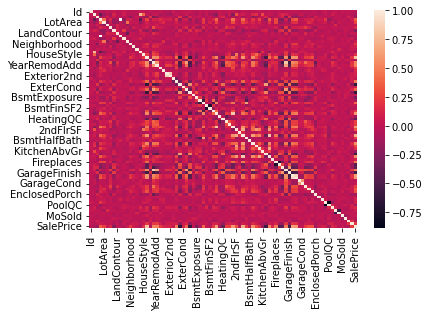

In [14]:
sns_plot = sns.heatmap(lc_data.corr())
fig = sns_plot.get_figure()
fig.savefig("figures/lc_data_heatmap")

In [15]:
threshold = 0.7

df_corr = lc_data.corr()

columns = np.full((df_corr.shape[0],), True, dtype=bool)

for i in range(df_corr.shape[0]):
    for j in range(i+1, df_corr.shape[0]):
        if df_corr.iloc[i,j] >= threshold:
            if columns[j]:
                columns[j] = False


selected_columns = lc_data.columns[~columns]
high_correlation = lc_data[selected_columns]

In [16]:
absolute_corr = np.abs(df_corr["SalePrice"])
df_corr["SalePrice"][absolute_corr > 0.5]

OverallQual     0.790982
YearBuilt       0.522897
YearRemodAdd    0.507101
ExterQual      -0.636884
BsmtQual       -0.620886
TotalBsmtSF     0.613581
1stFlrSF        0.605852
GrLivArea       0.708624
FullBath        0.560664
KitchenQual    -0.589189
TotRmsAbvGrd    0.533723
GarageFinish   -0.549247
GarageCars      0.640409
GarageArea      0.623431
SalePrice       1.000000
Name: SalePrice, dtype: float64

In [17]:
selected_columns

Index(['BldgType', 'Exterior2nd', '1stFlrSF', 'TotRmsAbvGrd', 'GarageYrBlt',
       'GarageArea', 'SalePrice'],
      dtype='object')

In [18]:
high_correlation.corr()

,BldgType,Exterior2nd,1stFlrSF,TotRmsAbvGrd,GarageYrBlt,GarageArea,SalePrice
BldgType,1.000000,-0.142748,-0.073688,-0.198413,0.200367,-0.061421,-0.085591
Exterior2nd,-0.142748,1.000000,0.017361,0.068503,0.155058,0.095006,0.103766
1stFlrSF,-0.073688,0.017361,1.000000,0.409516,0.233449,0.489782,0.605852
TotRmsAbvGrd,-0.198413,0.068503,0.409516,1.000000,0.148112,0.337822,0.533723
GarageYrBlt,0.200367,0.155058,0.233449,0.148112,1.000000,0.564567,0.486362
GarageArea,-0.061421,0.095006,0.489782,0.337822,0.564567,1.000000,0.623431
SalePrice,-0.085591,0.103766,0.605852,0.533723,0.486362,0.623431,1.000000


## Feature Processing (One Hot and Label Encoding)

In [139]:
data = pd.read_csv('data/House_Price.csv')

In [140]:
#selecting which columns to use label encoding on
#columns that compare the quality should be used or show that one category is better than
#another category should be used here
lccolumn = ['ExterQual','ExterCond','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','HeatingQC','CentralAir','KitchenQual','Functional','FireplaceQu','GarageFinish','GarageQual','GarageCond','PavedDrive','PoolQC','Fence']

In [141]:
#selecting which columns to use one hot encoding on
#ex: Streets should use the one hot encoder because the type of road 
#access should be based on whether it exists or not. 
ohccolumn = ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
             'Exterior1st','Exterior2nd', 'MasVnrType', 'Foundation','Heating','Electrical','GarageType','MiscFeature','SaleType','SaleCondition']

In [142]:
for column in ohccolumn:
    data = util.one_hot_encoding(data, column)

In [143]:
for column in lccolumn:
    data = util.label_encoder(data, column)

In [144]:
combined_data = data

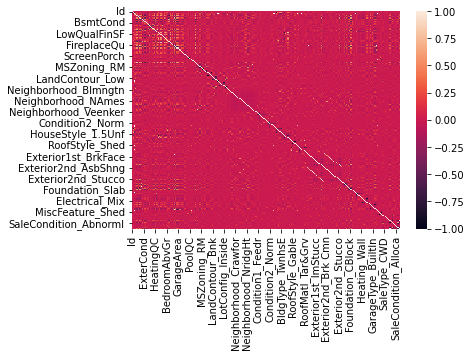

In [145]:
sns_plot = sns.heatmap(combined_data.corr())
fig = sns_plot.get_figure()
fig.savefig("figures/combined_data_heatmap")

In [146]:
threshold = 0.7

df_corr = combined_data.corr()

columns = np.full((df_corr.shape[0],), True, dtype=bool)

for i in range(df_corr.shape[0]):
    for j in range(i+1, df_corr.shape[0]):
        if df_corr.iloc[i,j] >= threshold:
            if columns[j]:
                columns[j] = False


selected_columns = combined_data.columns[~columns]
high_correlation = combined_data[selected_columns]

In [147]:
absolute_corr = np.abs(df_corr["SalePrice"])
df_corr["SalePrice"][absolute_corr > 0.5]

OverallQual     0.790982
YearBuilt       0.522897
YearRemodAdd    0.507101
ExterQual      -0.636884
BsmtQual       -0.620886
TotalBsmtSF     0.613581
1stFlrSF        0.605852
GrLivArea       0.708624
FullBath        0.560664
KitchenQual    -0.589189
TotRmsAbvGrd    0.533723
GarageFinish   -0.549247
GarageCars      0.640409
GarageArea      0.623431
SalePrice       1.000000
Name: SalePrice, dtype: float64

In [148]:
selected_columns

Index(['1stFlrSF', 'TotRmsAbvGrd', 'GarageYrBlt', 'GarageArea', 'SalePrice',
       'Neighborhood_Somerst', 'HouseStyle_2Story', 'RoofStyle_Shed',
       'RoofMatl_Tar&Grv', 'Exterior2nd_AsbShng', 'Exterior2nd_CBlock',
       'Exterior2nd_CmentBd', 'Exterior2nd_HdBoard', 'Exterior2nd_MetalSd',
       'Exterior2nd_Plywood', 'Exterior2nd_Stucco', 'Exterior2nd_VinylSd',
       'Exterior2nd_Wd Sdng', 'MiscFeature_Gar2', 'SaleCondition_Partial'],
      dtype='object')

In [149]:
high_correlation.corr().head()

,1stFlrSF,TotRmsAbvGrd,GarageYrBlt,GarageArea,SalePrice,Neighborhood_Somerst,HouseStyle_2Story,RoofStyle_Shed,RoofMatl_Tar&Grv,Exterior2nd_AsbShng,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_MetalSd,Exterior2nd_Plywood,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,MiscFeature_Gar2,SaleCondition_Partial
1stFlrSF,1.000000,0.409516,0.233449,0.489782,0.605852,-0.018495,-0.269813,0.017622,0.071021,-0.063332,-0.021856,0.080482,-0.039553,-0.144566,0.110230,0.014831,0.071504,-0.057258,-0.000300,0.221037
TotRmsAbvGrd,0.409516,1.000000,0.148112,0.337822,0.533723,-0.015275,0.430930,0.033786,-0.013142,0.002335,-0.008343,0.048695,-0.035270,-0.113001,-0.029205,0.049522,0.127698,-0.046896,0.045183,0.142032
GarageYrBlt,0.233449,0.148112,1.000000,0.564567,0.486362,0.277452,0.186831,-0.000782,-0.050926,-0.136388,-0.012559,0.113738,-0.047607,-0.198319,-0.055669,-0.136639,0.533014,-0.325996,-0.015451,0.349327
GarageArea,0.489782,0.337822,0.564567,1.000000,0.623431,0.184533,0.137946,0.020798,-0.006663,-0.092541,-0.016534,0.046189,-0.033155,-0.115115,-0.002738,0.001273,0.280274,-0.176492,-0.003896,0.294714
SalePrice,0.605852,0.533723,0.486362,0.623431,1.000000,0.140058,0.242880,0.020557,0.004921,-0.099220,-0.025028,0.128183,-0.067864,-0.162389,-0.052941,-0.042416,0.306389,-0.161800,-0.004744,0.352060


## Log Sale Price

/srv/conda/envs/housetools/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


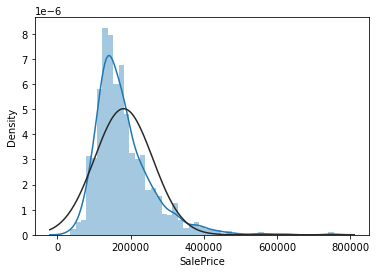

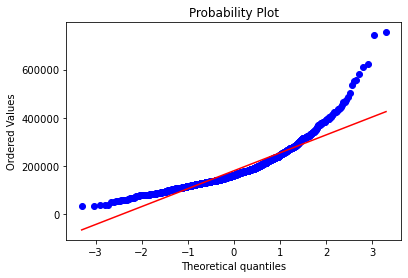

In [150]:
util.dist_and_prob_plot(data, 'SalePrice')

/srv/conda/envs/housetools/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


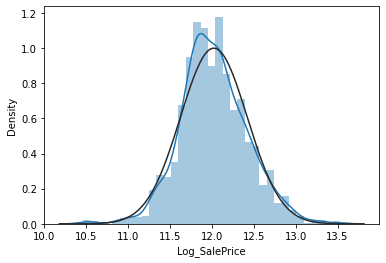

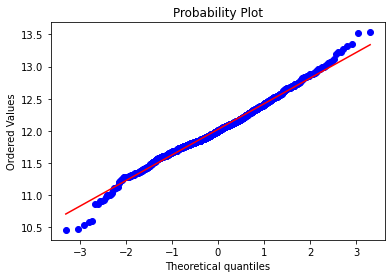

In [151]:
data['Log_SalePrice'] = np.log(data['SalePrice'])
util.dist_and_prob_plot(data, 'Log_SalePrice')

In [32]:
ohc_data['SalePrice'] = np.log(ohc_data['SalePrice'])
lc_data['SalePrice'] = np.log(lc_data['SalePrice'])
combined_data['SalePrice'] = np.log(combined_data['SalePrice'])

## Random Forest Model (One Hot Encoding)

In [33]:
ohc_data = ohc_data.dropna()
X = ohc_data.drop(['SalePrice', 'Id'], axis = 'columns')
y = ohc_data['SalePrice']

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12)
rf = RandomForestRegressor(n_estimators=500)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=500)

In [35]:
#made a dataframe with values greater than .001 importance
#sorted the values to look better on bargraph
dataframe = pd.DataFrame(rf.feature_importances_, rf.feature_names_in_)
a = dataframe[dataframe[0] > .001]
a = a.rename(columns = {0: 'values'})
b = a.sort_values('values', ascending = True)
b.head()

,values
BsmtFullBath,0.001081
KitchenQual_Ex,0.001132
Neighborhood_Crawfor,0.001156
KitchenQual_TA,0.001257
BsmtQual_TA,0.001313


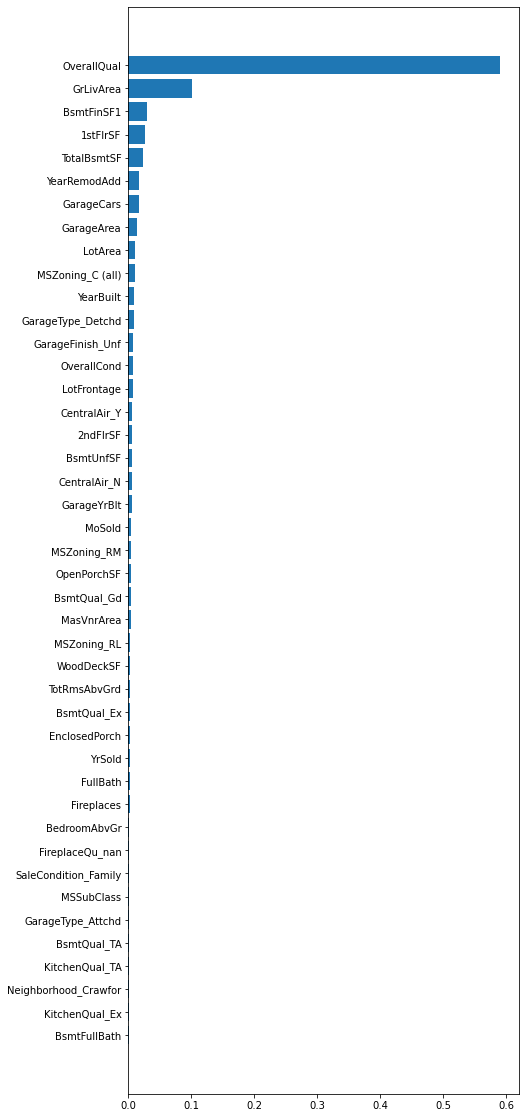

In [41]:
plt.figure(figsize=(7, 20))
plt.barh(b.index, b['values'])
plt.savefig('figures/Top 44 One Hot Encoding Feature Importance)')

In [37]:
#made another dataframe with a smaller importance threshold
dataframe = pd.DataFrame(rf.feature_importances_, rf.feature_names_in_)
c = dataframe[dataframe[0] > .01]
c = c.rename(columns = {0: 'values'})
d = c.sort_values('values', ascending = True)
d

,values
MSZoning_C (all),0.010085
LotArea,0.011035
GarageArea,0.014288
GarageCars,0.016755
YearRemodAdd,0.017418
TotalBsmtSF,0.023808
1stFlrSF,0.025788
BsmtFinSF1,0.028824
GrLivArea,0.100983
OverallQual,0.590504


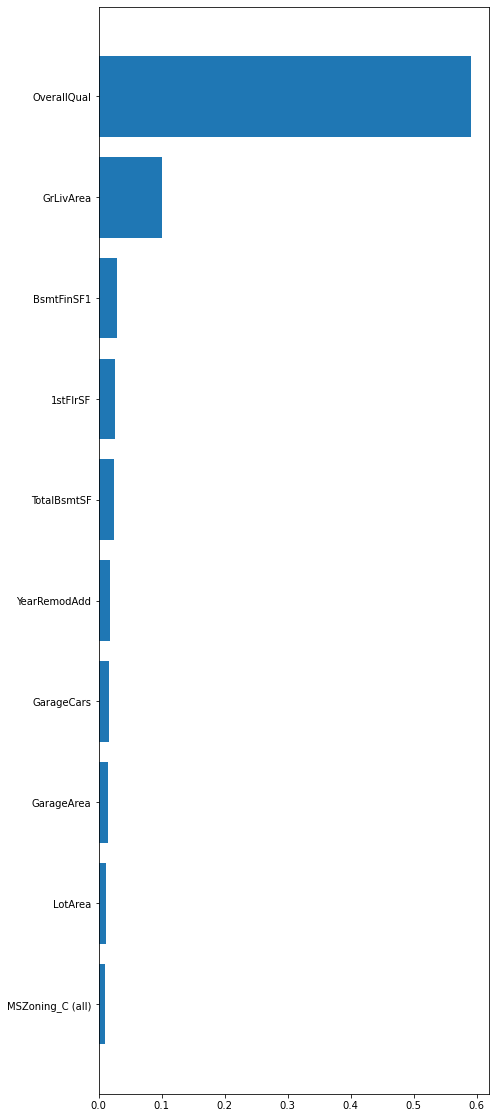

In [42]:
plt.figure(figsize=(7, 20))
plt.barh(d.index, d['values'])
plt.savefig('figures/Top 10 One Hot Encoding Feature Importance')

In [351]:
y_output = rf.predict(X_test)

In [352]:
print('MSE', mean_squared_error(y_test, y_output))
print('RMSE', math.sqrt(mean_squared_error(y_test, y_output)))
print('Adj R^2 value:', r2_score(y_test, y_output))

MSE 0.023397237595640556
RMSE 0.15296155594017916
Adj R^2 value: 0.8655196046473326


In [62]:
pd.DataFrame({'Type of Error':['MSE', 'RMSE', 'Adj R^2 Value'],'Value' : [mean_squared_error(y_test, y_output), (mean_squared_error(y_test, y_output))** (1/2),  r2_score(y_test, y_output)]}).set_index('Type of Error').to_csv('data/OHC_Error_Table.csv')

## Random Forest Model (Label Encoding)

In [66]:
lc_data = lc_data.dropna()
X = lc_data.drop(['SalePrice', 'Id'], axis = 'columns')
y = lc_data['SalePrice']

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12)
rf = RandomForestRegressor(n_estimators=500)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=500)

In [68]:
#made a dataframe with values greater than .001 importance
#sorted the values to look better on bargraph
dataframe = pd.DataFrame(rf.feature_importances_, rf.feature_names_in_)
a = dataframe[dataframe[0] > .001]
a = a.rename(columns = {0: 'values'})
b = a.sort_values('values', ascending = True)
b.head()

,values
ExterCond,0.001118
PavedDrive,0.001167
LotShape,0.001196
BsmtFullBath,0.001271
HeatingQC,0.001292


<BarContainer object of 45 artists>

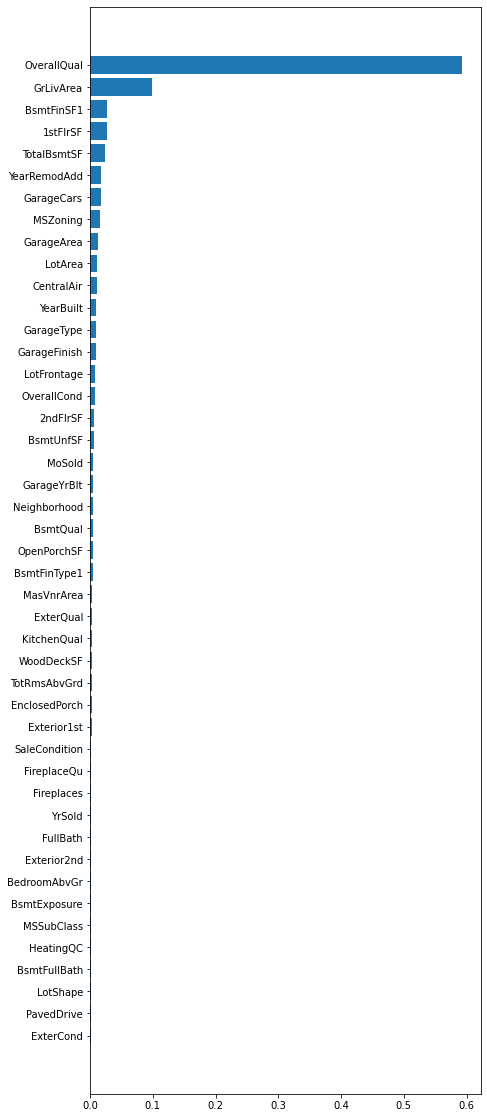

In [69]:
plt.figure(figsize=(7, 20))
plt.barh(b.index, b['values'])
plt.savefig('figures/Top 45 Label Encoding Feature Importance)')

In [71]:
#made another dataframe with a smaller importance threshold
dataframe = pd.DataFrame(rf.feature_importances_, rf.feature_names_in_)
c = dataframe[dataframe[0] > .01]
c = c.rename(columns = {0: 'values'})
d = c.sort_values('values', ascending = True)
d

,values
YearBuilt,0.010080
CentralAir,0.011582
LotArea,0.011840
GarageArea,0.013605
MSZoning,0.016032
GarageCars,0.017777
YearRemodAdd,0.018228
TotalBsmtSF,0.024533
1stFlrSF,0.027243
BsmtFinSF1,0.027307


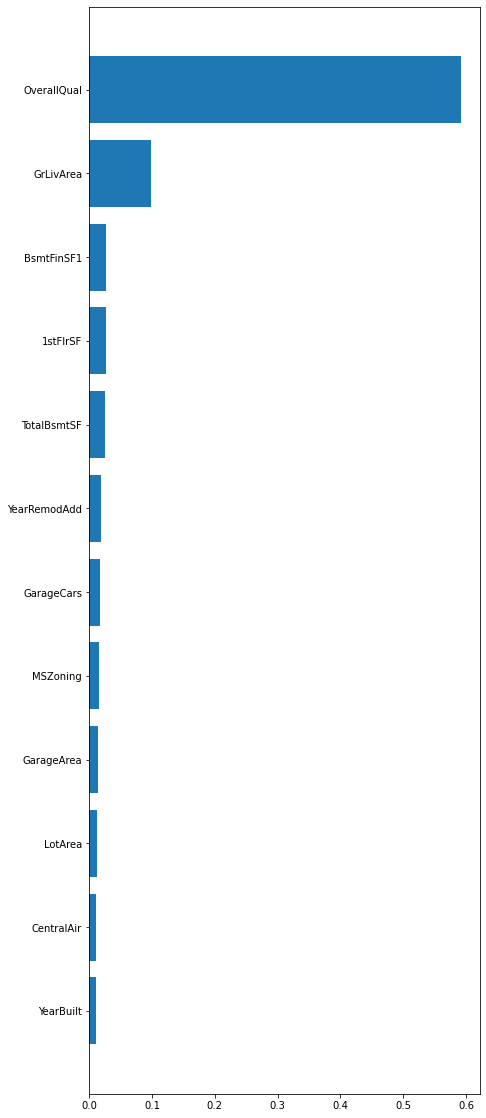

In [72]:
plt.figure(figsize=(7, 20))
plt.barh(d.index, d['values'])
plt.savefig('figures/Top 10 Label Encoding Feature Importance)')

In [100]:
y_output = rf.predict(X_test)

In [101]:
print('MSE', mean_squared_error(y_test, y_output))
print('RMSE', math.sqrt(mean_squared_error(y_test, y_output)))
print('Adj R^2 value:', r2_score(y_test, y_output))

MSE 0.00015989179376242943
RMSE 0.012644832690171484
Adj R^2 value: 0.8642769485910046


In [102]:
pd.DataFrame({'Type of Error':['MSE', 'RMSE', 'Adj R^2 Value'],'Value' : [mean_squared_error(y_test, y_output), (mean_squared_error(y_test, y_output))** (1/2),  r2_score(y_test, y_output)]}).set_index('Type of Error').to_csv('data/LC_Error_Table.csv')


## Random Forest Model(One Hot and Label Encoding)

In [73]:
combined_data = combined_data.dropna()
X = combined_data.drop(['SalePrice', 'Id'], axis = 'columns')
y = combined_data['SalePrice']

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12)
rf = RandomForestRegressor(n_estimators=500)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=500)

In [75]:
#made a dataframe with values greater than .001 importance
#sorted the values to look better on bargraph
dataframe = pd.DataFrame(rf.feature_importances_, rf.feature_names_in_)
a = dataframe[dataframe[0] > .001]
a = a.rename(columns = {0: 'values'})
b = a.sort_values('values', ascending = True)
b.head()

,values
PavedDrive,0.001130
ExterCond,0.001133
Neighborhood_Crawfor,0.001141
HeatingQC,0.001164
BsmtFullBath,0.001235


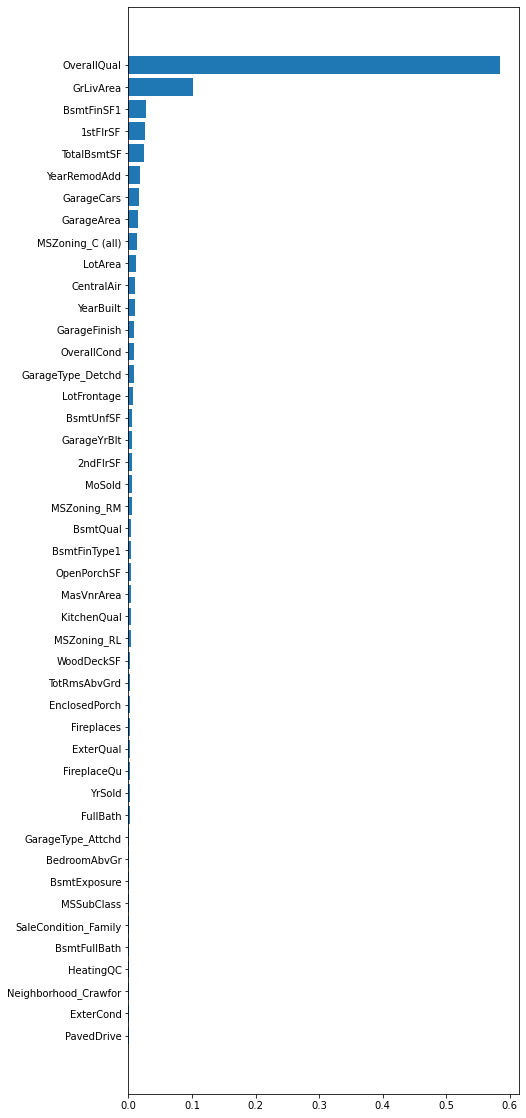

In [77]:
plt.figure(figsize=(7, 20))
plt.barh(b.index, b['values'])
plt.savefig('figures/Top 45 Combined Encoding Feature Importance)')

In [295]:
#made another dataframe with a smaller importance threshold
dataframe = pd.DataFrame(rf.feature_importances_, rf.feature_names_in_)
c = dataframe[dataframe[0] > .01]
c = c.rename(columns = {0: 'values'})
d = c.sort_values('values', ascending = True)
d

,values
LotArea,0.011152
CentralAir,0.011860
MSZoning_0,0.013596
GarageCars,0.014533
GarageArea,0.014900
YearRemodAdd,0.017539
TotalBsmtSF,0.023884
1stFlrSF,0.025663
BsmtFinSF1,0.026292
GrLivArea,0.099646


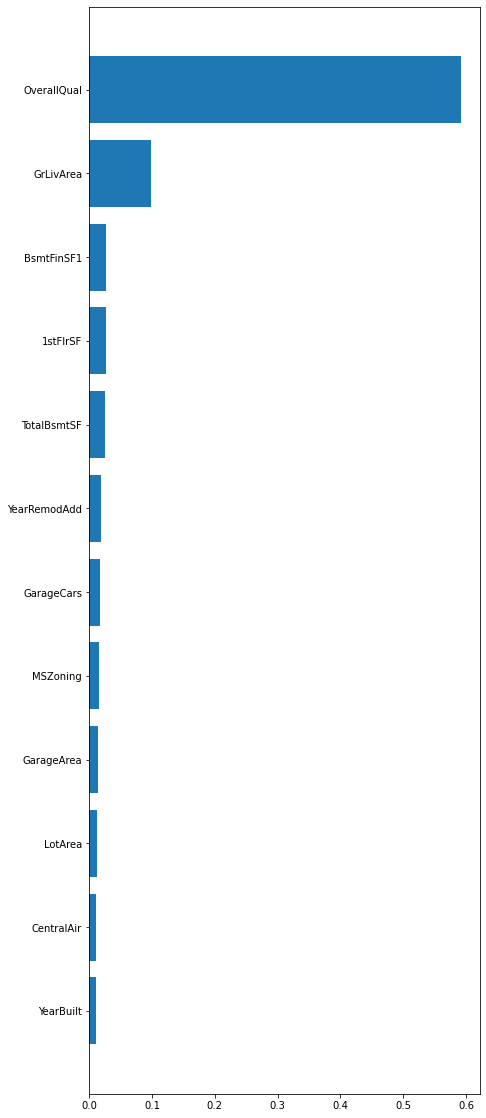

In [78]:
plt.figure(figsize=(7, 20))
plt.barh(d.index, d['values'])
plt.savefig('figures/Top 11 Combined Encoding Feature Importance)')

In [80]:
y_output = rf.predict(X_test)

In [91]:
print('MSE', mean_squared_error(y_test, y_output))
print('RMSE', (mean_squared_error(y_test, y_output))** (1/2))
print('Adj R^2 value:', r2_score(y_test, y_output))

MSE 0.00015989179376242943
RMSE 0.012644832690171484
Adj R^2 value: 0.8642769485910046


In [98]:
pd.DataFrame({'Type of Error':['MSE', 'RMSE', 'Adj R^2 Value'],'Value' : [mean_squared_error(y_test, y_output), (mean_squared_error(y_test, y_output))** (1/2),  r2_score(y_test, y_output)]}).set_index('Type of Error').to_csv('data/Combined_Error_Table.csv')







## Author Contributions:

Isaac: 

Brandon:

Raj: 